# Complex Waves

This notebook is a demonstration of a way to track frequency that Jamey suggested to me. It involves a complex frequency term, and a phase term. The frequency term is below, it is formed as a complex exponential, and results in an unit of change per sample.

$$ freq = \frac{\Delta phase}{sample} = e^{j \omega \frac{f}{f_s}}$$

The phase is initialized at 0 + 1j for sine (or vice versa), and the frequency per sample term is multiplied by the phase of each sample. The phase does not exceed 2pi radians this way. Also note that you may  switch between the sine and cosines by using the real and imaginary parts.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


##Grabs the GoldCode module from the root of the repo
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from GoldCode import GoldCode
from GPSData import IQData

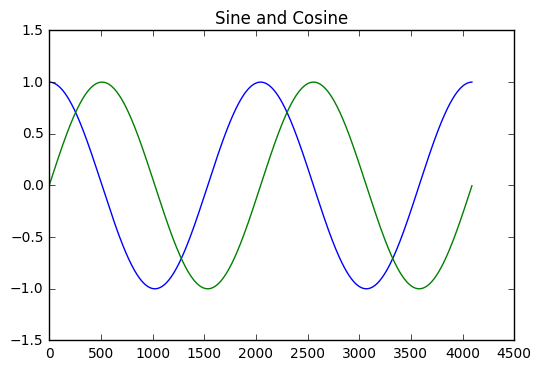

In [2]:
#Pick frequencies
fs = 4.092*10**6 # Sampling Frequency [Hz]
ff = 2000  # Wave Frequency [Hz] 

#Initialize terms
freq = np.exp(1j * 2 * np.pi * (ff/fs))
phase = 1 + 0j

#Init samples
wav = np.zeros(4092, dtype = 'complex')


for n, w in enumerate(wav):
    wav[n] = phase
    phase = phase * freq
    
plt.plot(np.real(wav)) #Cos
plt.plot(np.imag(wav)) #Sin

plt.title('Sine and Cosine')
plt.show()

So now we are travelling around the unit circle, and we can use arctan to give us the phase error. The phase and frequency errors are essentially the same, but it is difficult to tell whether the phase error results from frequency or just phase. If assume frequency, and make adjustments over time, a phase error will correct itself. 

The plot below shows the phase vector moving around the circle over the first few hundred samples.

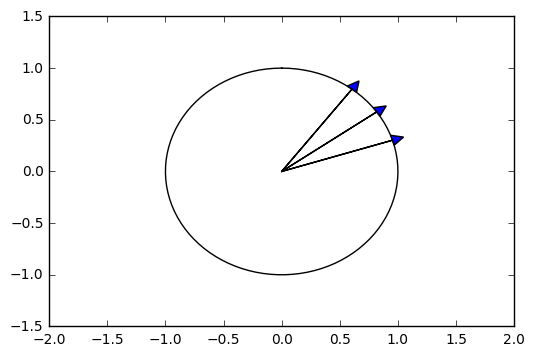

In [3]:
t = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.sin(t), np.cos(t), color = 'k')
plt.ylim([-1.5, 1.5])
plt.xlim([-2, 2])

ax = plt.axes()
ax.arrow(0, 0, np.real(wav[100]), np.imag(wav[100]), head_width=.1, head_length = .1)
ax.arrow(0, 0, np.real(wav[200]), np.imag(wav[200]), head_width=.1, head_length = .1)
ax.arrow(0, 0, np.real(wav[300]), np.imag(wav[300]), head_width=.1, head_length = .1)

plt.show()

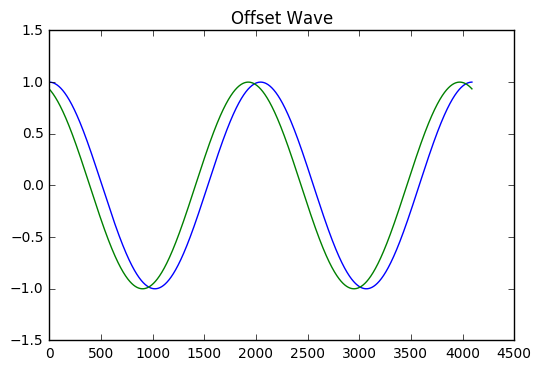

In [4]:
#Now create a wave with a phase offset

#Initialize terms
freq = np.exp(1j * 2 * np.pi * (ff/fs))
pOffset = np.deg2rad(21) 

phase = np.exp(1j * pOffset)

#Init samples
wavOffset = np.zeros(4092, dtype = 'complex')


for n, w in enumerate(wav):
    wavOffset[n] = phase
    phase = phase * freq

plt.plot(np.real(wav)) #ref
plt.plot(np.real(wavOffset)) #offset

plt.title('Offset Wave')
plt.show()

In the unit circle plot below, we can see that the phase error between these two waves is constant. The blue arrow does not move as the other two travel around. Change the s value to see the vectors in other positions.

Phase difference [rad:]
21.0


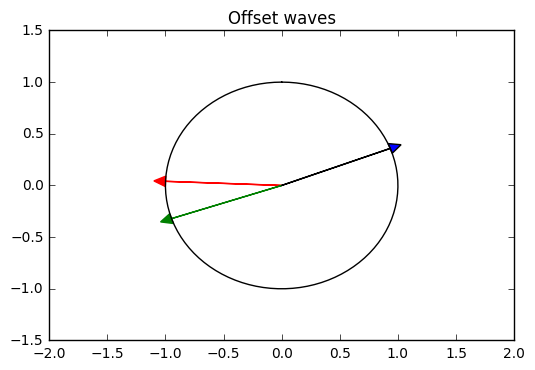

In [5]:
t = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.sin(t), np.cos(t), color = 'k')
plt.ylim([-1.5, 1.5])
plt.xlim([-2, 2])

s = 1010 #Set the sample index for the circle plot(arbitrary)

ax = plt.axes()
ax.arrow(0, 0, np.real(wav[s]), np.imag(wav[s]), head_width=.1, head_length = .1, color = 'red')
ax.arrow(0, 0, np.real(wavOffset[s]), np.imag(wavOffset[s]), head_width=.1, head_length = .1, color='green')

#Calculate phase difference
diff = wavOffset[s] / wav[s]

print('Phase difference [rad:]')
print(np.rad2deg(np.angle(diff)))

ax.arrow(0, 0, np.real(diff), np.imag(diff), head_width=.1, head_length = .1)

plt.title('Offset waves')
plt.show()

Now we need to come up with a way to correct the phase angle so that it is 0. 

After that we will do the same to IQ data by correcting the quadrature to the inphase. 

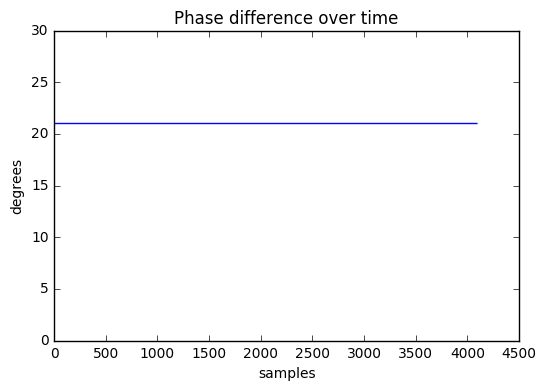

In [6]:
anglevec = np.rad2deg(np.angle(wavOffset / wav)) #phase offset over time [rad/sample]
plt.plot(anglevec )
plt.ylim([0,30])
plt.title('Phase difference over time')
plt.xlabel('samples')
plt.ylabel('degrees')
plt.show()

# Calculate Filter parameters

- $\zeta$ (zeta) is the damping ratio
- $K$ is the loop gain
- $\beta$ (bandwidth) is the loop noise bandwidth

The natural frequency is calculated from (7.18) in Borre. The filter parameters $\tau_1$ and $\tau_2$ are derived from (7.10), and the included code. The book appears to implement the s domain functions in equations (7.7) and (7.8) although they go on to discuss the z domain transfer functions later in the section. 

using 7000 for $\frac{\tau_1}{\tau_2}$ and 20 for $\frac{t_s}{\tau_2}$ gives a favorable result, but these values were just guessed. 


In [513]:
zeta = .7
bandwidth = 20
k = .02
inter = 10

wn = (bandwidth * 8 * zeta) /\
    (4 * zeta ** 2 + 1)
    
t1 = k / (wn * wn)
t2 = (zeta * 2.0) / wn


print(wn)
print(t1)
print(t2)

37.83783783783784
1.3969387755102042e-05
0.037


In [514]:
#Set up the incoming wave

#Pick frequencies
fs = 4.092*10**6 # Sampling Frequency [Hz]
ff = 2000  # Wave Frequency [Hz] 

#Make the incoming wave
incFreq = np.exp(1j * 2 * np.pi * (ff/fs))
pOffset = np.deg2rad(-95) 
incPhase = np.exp(1j * pOffset)

incWav = np.zeros(4092 * 2, dtype = 'complex')
for n, w in enumerate(incWav):
    incWav[n] = incPhase
    incPhase = incPhase * incFreq

#Logging Vectors
refWave = np.zeros(len(incWav), dtype='complex')
m = np.zeros(len(incWav))
discriminator = np.zeros(len(incWav))
rf = np.zeros(len(incWav))


#Initialize vars
baseF = ff
refFreq = baseF #Initial frequency

refphase = 1 + 0j #Initial phase

refWave[0] = refphase

adjustment = 0
oldErr = 0
oldRef = 0

#summation interval
interval = 1/fs

#iterate over every sample and adjust
r = [] #ref frequency recording

#iterate over every sample and adjust
for n, samp in enumerate(incWav):
    #Mix
    mixed = incWav[n] / refWave[n]
    #m[n] = mixed
    
    #Check discriminator
    #d = np.angle(mixed) / (2*np.pi)
    d = np.arctan(np.imag(mixed)/np.real(mixed)) / (2*np.pi)
    discriminator[n] = d #Save discriminator
    
    
    #Adjust frequency
    adjustment = oldRef + (d - oldErr) * (t2/t1) + d * (inter/t2)#(7000) + d * 20    
    refFreq = baseF +  adjustment     
    oldRef = adjustment
    
    r.append(refFreq)
    
    oldErr = d
    
    #Calculate next reference frequency sample
    if (n<len(incWav)-1):
        refWave[n + 1] = refWave[n] * np.exp(1j * 2 * np.pi * (refFreq/fs))
    can[n] = refWave[n] * np.conj(incWav[n])

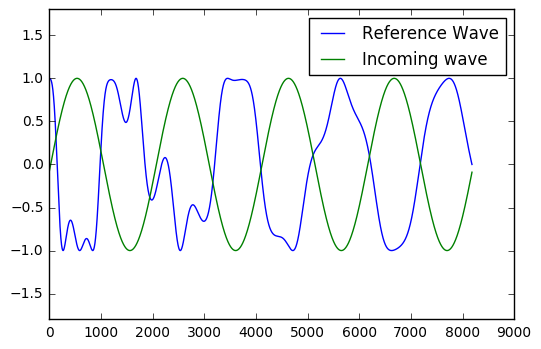

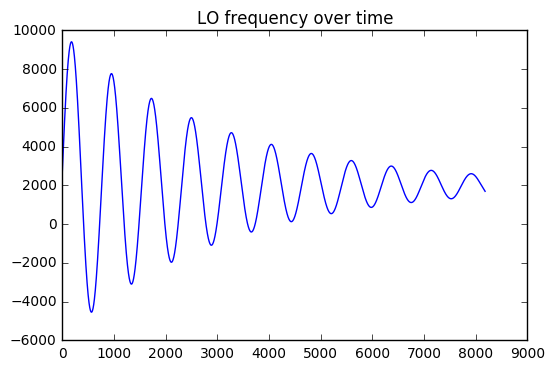

/usr/lib/python3/dist-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


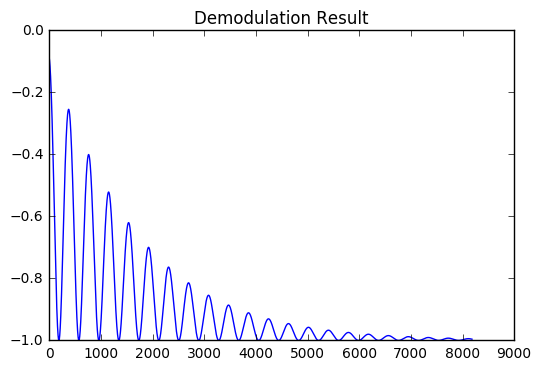

In [515]:
#plt.plot(discriminator)
#plt.show()
plt.plot(np.real(refWave), label = 'Reference Wave')
plt.plot(np.real(incWav), label = 'Incoming wave')
plt.ylim([-1.8, 1.8])
plt.legend()
plt.show()

plt.plot(r)
plt.title('LO frequency over time')
plt.show()

plt.plot(incWav * np.conj(refWave))
plt.title("Demodulation Result")
plt.show()

#plt.plot(discriminator)
#plt.show()


# Lock on to wave that changes frequency over time

The primary reason to create this PLL is to track a Doppler shift a spacecraft moves across the sky over time. The incoming wave is now called the changing wave as it changes frequencies over the sample.

In [516]:
#Set up the incoming wave

fs = 4.092*10**6 # Sampling Frequency [Hz]

changingWav = np.zeros(4092 * 2, dtype = 'complex')

#Set start and stop frequencies below
fList = np.linspace(1000, 8000, len(changingWav))
#bList = np.zeros(len(changingwav))
#Make the incoming wave
changingFreq = np.exp(1j * 2 * np.pi * (fList/fs))

pOffset = np.deg2rad(-95) 
changingPhase = np.exp(1j * pOffset)



for n, w in enumerate(changingWav):
    changingWav[n] = changingPhase
    changingPhase = changingPhase * changingFreq[n] 
    if (n % 2000 == 1):
        changingPhase = -changingPhase 

#Logging Vectors
refWave = np.zeros(len(changingWav), dtype='complex')
m = np.zeros(len(changingWav))
discriminator = np.zeros(len(changingWav))
rf = np.zeros(len(changingWav))
can = np.zeros(len(changingWav), dtype = 'complex')

#Initialize vars
baseF = fList[0]
refFreq = baseF #Initial frequency

refphase = 1 + 0j #Initial phase

refWave[0] = refphase

adjustment = 0
oldErr = 0
oldRef = 0

r = [] #ref frequency recording

#iterate over every sample and adjust
for n, samp in enumerate(changingWav):
    #Mix
    mixed = changingWav[n] / refWave[n]
    #m[n] = mixed
    
    #Check discriminator
    #d = np.angle(mixed) / (2*np.pi)
    d = np.arctan(np.imag(mixed)/np.real(mixed)) / (2*np.pi)
    discriminator[n] = d #Save discriminator
    
    
    #Adjust frequency
    adjustment = oldRef + (d - oldErr) * (t2/t1) + d * (inter/t2)#(7000) + d * 20    
    refFreq = baseF +  adjustment     
    oldRef = adjustment
    
    r.append(refFreq)
    
    oldErr = d
    
    #Calculate next reference frequency sample
    if (n<len(incWav)-1):
        refWave[n + 1] = refWave[n] * np.exp(1j * 2 * np.pi * (refFreq/fs))
    can[n] = refWave[n] * np.conj(changingWav[n])

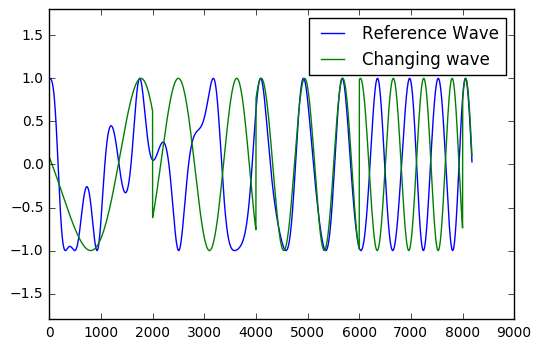

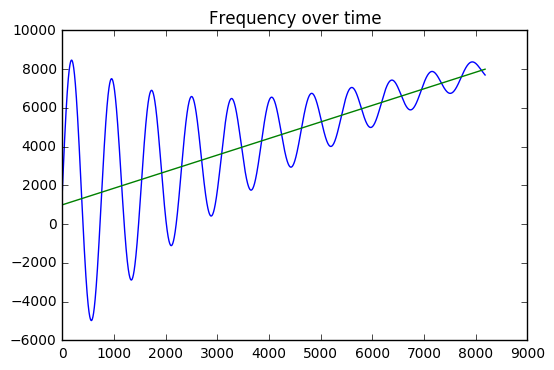

/usr/lib/python3/dist-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


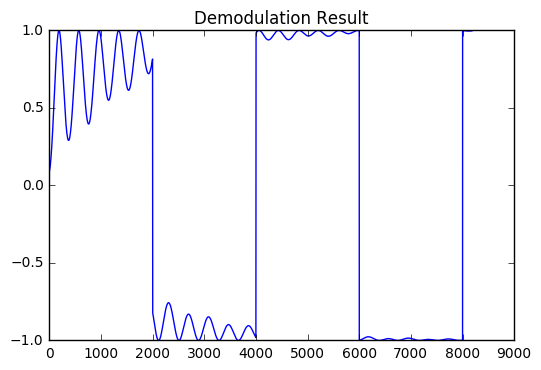

In [517]:
#plt.plot(discriminator)
#plt.show()
plt.plot(np.real(refWave), label = 'Reference Wave')
plt.plot(np.real(changingWav), label = 'Changing wave')
plt.ylim([-1.8, 1.8])
plt.legend()
plt.show()

plt.plot(r)
plt.plot(fList)
plt.title('Frequency over time')
plt.show()

plt.plot(changingWav * np.conj(refWave))
plt.title("Demodulation Result")
plt.show()

# Track a wave with noise

In [491]:
# Adjust the noise level below (middle arg)
noise = np.random.normal(0, 1, len(incWav))

nonoise = changingWav
incWav = changingWav + noise

#Logging Vectors
refWave = np.zeros(len(incWav), dtype='complex')
m = np.zeros(len(incWav))
discriminator = np.zeros(len(incWav))
rf = np.zeros(len(incWav))


#Initialize vars
baseF = ff
refFreq = baseF #Initial frequency

refphase = 1 + 0j #Initial phase

refWave[0] = refphase

r = []

adjustment = 0
oldErr = 0
oldRef = 0

#iterate over every sample and adjust
for n, samp in enumerate(incWav):
    #Mix
    mixed = incWav[n] / refWave[n]
    #m[n] = mixed
    
    #Check discriminator
    d = np.arctan(np.imag(mixed)/np.real(mixed)) / (2*np.pi)
    discriminator[n] = d #Save discriminator
    
    
    #Adjust frequency
    adjustment = oldRef + (d - oldErr) * (t2/t1) + d * (inter/t2)#(7000) + d * 20    
    refFreq = baseF +  adjustment     
    oldRef = adjustment
    
    r.append(refFreq)
    
    oldErr = d
    
    #Calculate next reference frequency sample
    if (n<len(incWav)-1):
        refWave[n + 1] = refWave[n] * np.exp(1j * 2 * np.pi * (refFreq/fs))
    



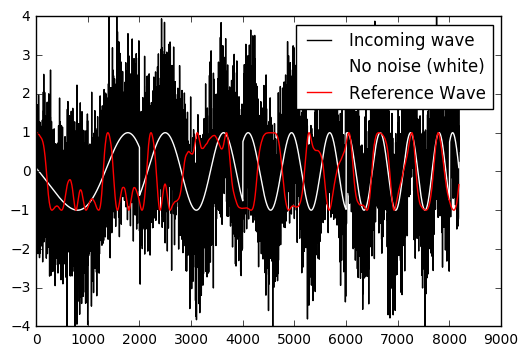

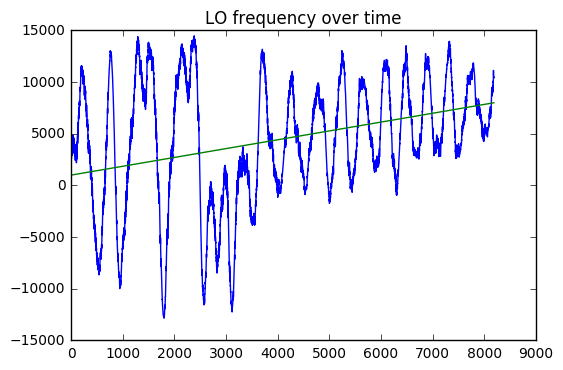

/usr/lib/python3/dist-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


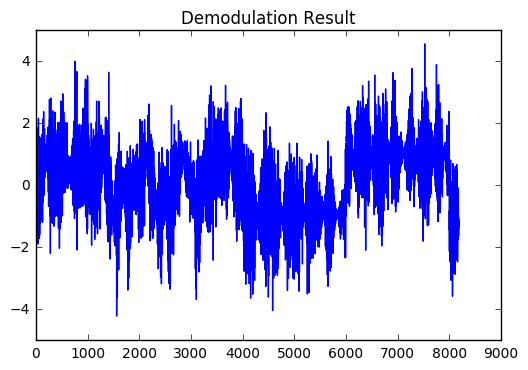

In [492]:
#plt.plot(discriminator)
#plt.show()
plt.plot(np.real(incWav), color = 'k', label = 'Incoming wave')
plt.plot(np.real(nonoise), color = 'white', label = 'No noise (white)')
plt.plot(np.real(refWave), color = 'r', label = 'Reference Wave')

plt.ylim([-4, 4])
plt.legend()
plt.show()

plt.plot(r)
plt.plot(fList)
plt.title('LO frequency over time')
plt.show()

plt.plot(incWav * np.conj(refWave))
plt.title("Demodulation Result")
plt.show()

In [431]:
signal = incWav

output = []
phi_hat = 0.3      # phi_hat is the output phase 
freq_offset = 0.3
delta_phi = 0.0    # delta_phi is the phase difference between the incomming signal and the VCO
Bn = 20
Zeta = 0.707       # Damping factor of the loop
wn = (2*Bn) / (Zeta + 1/(4*Zeta))          # wn is omega_n, pll bandwidth
fs = 4.092 *10**6  # Sampling frequency
ts = 1/fs          # Sampling time
t = 1* 10**-3
K = 1000           # K = loop gain, which I assume can be chosen, but this is a sample value
N = fs*t         # Number of samples

noise_power = 0
noise_mean = 0


# These are just initializing some vectors for plotting
ref = np.linspace(0, N, N)
# Clear buffers
v0 = 0.0           
v1 = 0.0           
v2 = 0.0      

#Set parameters for feedback equation above
a0 = 1.0
a1 = -1.999734
a2 = 0.999969



t1 = K/(wn*wn)     # tau_1
t2 = 2*Zeta/wn     # tau_2
print('t1 =%f' %t1)
print('t2 =%f' %t2)

b0 = -0.000059 #(4*K/t1) * (1.0+t2/2.0)
b1 = -0.000118 #8*K/t1
b2 = -0.000059 #(4*K/t1) * (1.0-t2/2.0)

for sample in signal:

    # Complex oscillator signal
    lpf = np.cos(phi_hat) + 1j*np.sin(phi_hat)

    delta_phi = np.angle( sample * np.conj( lpf))
    output.append(lpf)

    # vx varibles are a buffer to store output changes on transfer function variables ax and bx
    v2 =  v1
    v1 =  v0
    v0 =  delta_phi - v1 * a1 - v2 * a2
    phi_hat =  v0 * b0 + v1 * b1 + v2* b2

t1 =0.703054
t2 =0.037492


/usr/lib/python3/dist-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


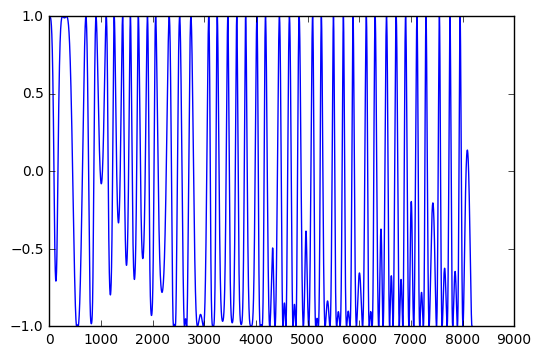

In [298]:
plt.plot(output)
plt.show()